# Nonlinear optimization, camera calibration

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize

from lib import (
    projectpoints, triangulate, checkerboard_points, calibrateCamera
)

In [2]:
def homogeneous(Q):
    r, c = Q.shape
    if r not in [2, 3]:
        warnings.warn("Unexpected dimension")
    return np.vstack((Q, np.ones(c)))

## Nonlinear optimization

In [3]:
R1 = np.eye(3)
R2 = np.eye(3)
t1 = np.array([0, 0, 1]).reshape(3, 1)
t2 = np.array([0, 0, 20]).reshape(3, 1)

K1 = np.array([
    [700, 0  , 600],
    [0  , 700, 400],
    [0  , 0  , 1  ],
])
K2 = K1

Q = np.array([1, 1, 0, 1]).reshape(4, 1)

### 1. Projections

In [4]:
P1 = K1 @ np.hstack([R1, t1])
P2 = K2 @ np.hstack([R2, t2])
q1 = P1 @ Q
q2 = P2 @ Q
q1 = q1 / q1[2]
q2 = q2 / q2[2]
q1, q2

(array([[1.3e+03],
        [1.1e+03],
        [1.0e+00]]),
 array([[635.],
        [435.],
        [  1.]]))

### 2. Noise

In [5]:
noise = np.array([1, -1, 0]).reshape(3, 1)
q1_tilde = q1 + noise
q2_tilde = q2 + noise

Q_tilde = np.vstack((
    triangulate(np.hstack([q1_tilde, q2_tilde]), [P1, P2]),
    1
))
print(f"Q_tilde:\n {Q_tilde}")

Q_tilde:
 [[1.01527507e+00]
 [9.85270570e-01]
 [2.85786810e-04]
 [1.00000000e+00]]


#### Reprojection error of the cameras:

In [6]:
reprojection1 = P1 @ Q_tilde
reprojection2 = P2 @ Q_tilde
reprojection1 = reprojection1 / reprojection1[2]
reprojection2 = reprojection2 / reprojection2[2]

err1 = np.linalg.norm(q1_tilde - reprojection1) / np.linalg.norm(q1_tilde)
err2 = np.linalg.norm(q2_tilde - reprojection2) / np.linalg.norm(q2_tilde)

print("||(q1_tilde - P1 Q_tilde)|| / ||q1_tilde|| = {:.2e}".format(err1))
print("||(q2_tilde - P2 Q_tilde)|| / ||q2_tilde|| = {:.2e}".format(err2))

||(q1_tilde - P1 Q_tilde)|| / ||q1_tilde|| = 7.89e-03
||(q2_tilde - P2 Q_tilde)|| / ||q2_tilde|| = 8.72e-04


#### Distance from $\tilde{\mathit{Q}}$ to $\mathit{Q}$:

In [7]:
Q_tilde = triangulate(np.hstack([q1_tilde, q2_tilde]), [P1, P2])
print("Absolute error: {:.0e}".format(np.linalg.norm(Q_tilde - Q[:3])))

Absolute error: 2e-02


### 3. Non linear triangulation

In [8]:
def triangulate_nonlin(q, P):
    """Triangulate using nonlinear optimisation.
    
    Parameters
    ----------
    q: 3 x n numpy array
        Pixel coordinates q1... qn
    P: list of 3 x 4 numpy arrays
        Projection matrices P1... Pn
    
    Return
    ------
    Q: 3 x 1 numpy array
        Triangulation of the point using the linear algorithm
    """
    n = len(P)
    x0 = triangulate(q, P).reshape(3)

    def compute_residuals(Q):
        Q = Q.reshape(3, 1)
        absolute_errors = np.zeros(2 * n)
        for i in range(n):
            qh = P[i] @ np.vstack((Q, 1))
            qr = qh[:2].reshape(2) / qh[2]
            absolute_errors[2 * i: 2 * i + 2] = qr - q[:2, i]
        return absolute_errors
    
    res = scipy.optimize.least_squares(compute_residuals, x0)
    return res["x"].reshape(3, 1)

### 4. Reprojection error with non linear triangulation

In [9]:
Q_tilde = triangulate_nonlin(np.hstack([q1_tilde, q2_tilde]), [P1, P2])

print("Absolute error: {:.0e}".format(np.linalg.norm(Q_tilde - Q[:3])))

Absolute error: 2e-03


## Camera calibration with OpenCV

### 5. The calibration target - find corners

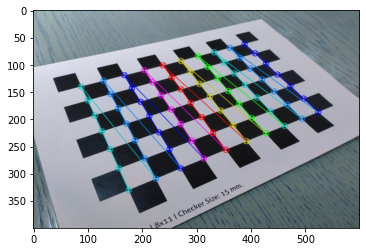

In [10]:
Is = []
qs_detected = []
imagepoints = []
h, w = 7, 10

for i in range(20):
    # load image
    im = cv2.imread("data/checkerboard/c{:02d}.jpg".format(i))
    im = cv2.resize(im, (600, 400))

    gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (h, w))
    if ret == True:
        # save image
        Is.append(im)
        # Draw and display the corners
        im_painted = cv2.drawChessboardCorners(im.copy(), (h, w), corners, ret)
        imagepoints.append(corners)
        qh = homogeneous(corners.reshape(-1, 2).T)
        qs_detected.append(qh)
        cv2.imshow('img', im_painted)
        cv2.waitKey(500)

cv2.destroyAllWindows()
plt.imshow(im_painted);

### 7 Camera calibration

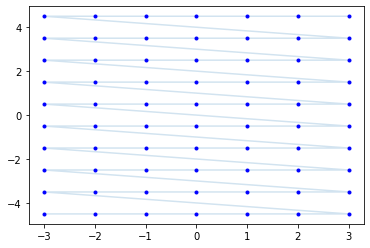

In [11]:
Q = homogeneous(checkerboard_points(7, 10))
plt.plot(Q[0,:], Q[1,:], alpha=0.2)
plt.plot(Q[0,:], Q[1,:], 'b.')
K, Rs, ts = calibrateCamera(qs=qs_detected, Q=Q)

In [12]:
K

array([[802.87703561,  81.60622493, 402.26010233],
       [  0.        , 565.55527389,  29.01651499],
       [  0.        ,   0.        ,   1.        ]])

### 8. Reprojection of the checkerboard

In [13]:
def get_reprojection_images(Is, K, Rs, ts, distortion_coeff=[0, 0, 0]):
    reprojection = []
    qs=[]
    for i, im in enumerate(Is):
        im_copy = im.copy()
        # Projection
        q = projectpoints(K, Rs[i], ts[i], Q, distortion_coeff)
        qs.append(q)
        # Draw all points onto images
        for k in range(len(q[0])):
            cv2.circle(
                img=im_copy,
                center=(int(q[0, k]), int(q[1, k])),
                radius=1,
                color=(255,0,0),
                thickness=4
            )
        reprojection.append(im_copy)
    return qs, reprojection

Highest reprojection error (summed on corners): 4.463 pixels


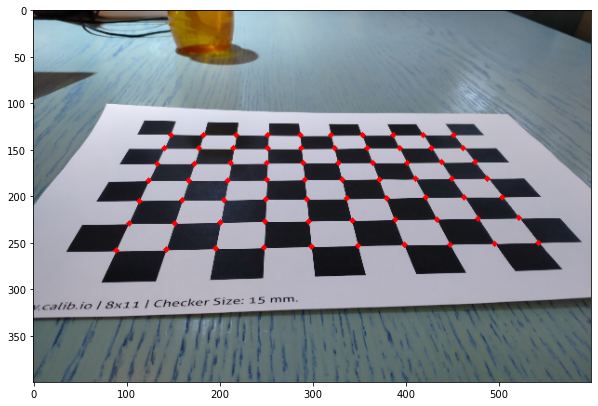

In [19]:
qs_reprojected, I_projection = get_reprojection_images(Is, K, Rs, ts)
absolute_error = [
    np.linalg.norm(qs_detected[i] - qs_reprojected[i]) for i in range(len(Is))
]
i_max_error = np.argmax(absolute_error)

fig, ax = plt.subplots(1, figsize=(10, 10))
ax.imshow(I_projection[i_max_error]);
print("Highest reprojection error (summed on corners): {:.3f} pixels".format(absolute_error[i_max_error]))

### With cv2

In [36]:
objpoints = [np.float32(Q[:3].T)] * len(imagepoints)
flags=(
    cv2.CALIB_FIX_K3 + cv2.CALIB_FIX_K4 + cv2.CALIB_FIX_K5
    + cv2.CALIB_FIX_K6 + cv2.CALIB_ZERO_TANGENT_DIST
)
ret, K_cv, distortion_coefficients, rvecs, tvecs = cv2.calibrateCamera(
    objpoints, imagepoints, gray.shape[::-1], None, None, flags=flags
)

Rs_cv = []
for rvec in rvecs:
    R, _ = cv2.Rodrigues(rvec)
    Rs_cv.append(R)

ts_cv = np.asarray(tvecs)

Highest cv reprojection error (summed on corners): 89.194 pixels


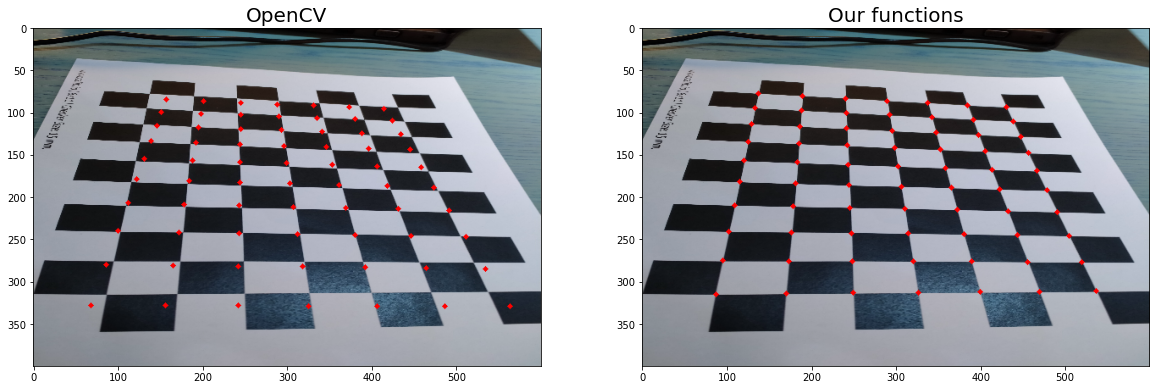

In [37]:
qs_reprojected_cv, I_projection_cv = get_reprojection_images(Is, K_cv, Rs_cv, ts_cv)
absolute_error = [
    np.linalg.norm(qs_detected[i] - qs_reprojected_cv[i]) for i in range(len(Is))
]
i_max_error = np.argmax(absolute_error)

fi, ax = plt.subplots(1, 2, figsize=(20, 20))
ax[0].imshow(I_projection_cv[i_max_error]);
ax[1].imshow(I_projection[i_max_error]);
ax[0].set_title("OpenCV", fontsize=20)
ax[1].set_title("Our functions", fontsize=20)

print("Highest cv reprojection error (summed on corners): {:.3f} pixels".format(absolute_error[i_max_error]))

### 9. Distortion

In [38]:
distortion_coefficients[0]

array([ 0.02283437, -0.22108829,  0.        ,  0.        ,  0.        ])

Highest reprojection error (summed on corners): 72.834 pixels


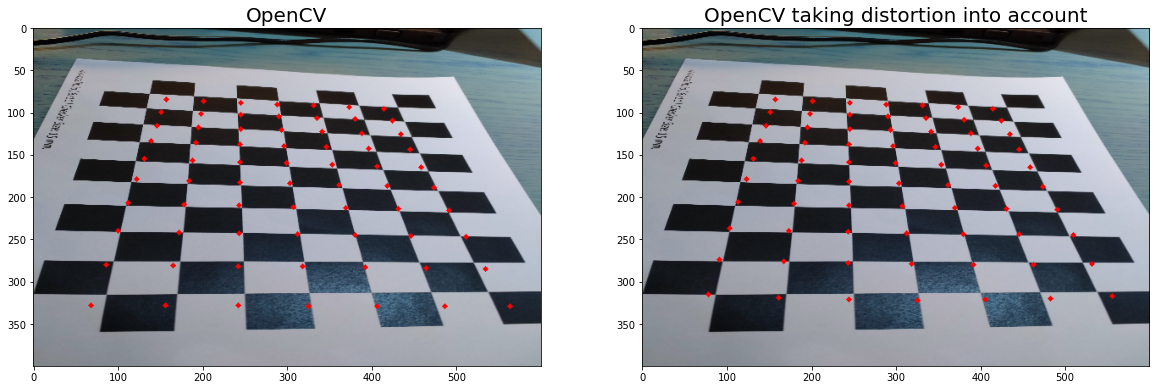

In [41]:
qs_reprojected_d, I_projection_d = get_reprojection_images(
    Is, K_cv, Rs_cv, ts_cv,
    distortion_coeff=distortion_coefficients[0][:3]
)
absolute_error = [
    np.linalg.norm(qs_detected[i] - qs_reprojected_d[i]) for i in range(len(Is))
]
i_max_error = np.argmax(absolute_error)

fig, ax = plt.subplots(1, 2, figsize=(20, 20))
ax[0].imshow(I_projection_cv[i_max_error]);
ax[1].imshow(I_projection_d[i_max_error]);
ax[0].set_title("OpenCV", fontsize=20)
ax[1].set_title("OpenCV taking distortion into account", fontsize=20)
print(
    "Highest reprojection error (summed on corners): {:.3f} pixels".format(
        absolute_error[i_max_error]
    )
)

It improves a little the cv2 results, but based on 8. we can say that the problem is not in the distortion but in cv2 calibration